<a href="https://colab.research.google.com/github/HassaniAtefe/ai-or-not/blob/main/AI_or_Not%3F_AI_Generated_Images_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI or Not? AI Generated Images Detector


**Generated by AI detector**: The pipeline of training a model to detect if images are generated by AI or not:

1. Finding a dataset of natural images and images generated by AI (here is one such dataset on the [Hugging Face Hub](https://huggingface.co/datasets/competitions/aiornot)
2. Createing a training and test set.
3. Building a neural network
4. Training it to classify the image as being generated by an AI or not until a reasonable accuracy is reached

#### The link of uploaded model to Hugging Face Hub:

https://huggingface.co/AtefeHassani/vit-base-patch16-224-in21k-aiornot/tree/main

In [3]:
# Testing for GPU in order to running the code
# You can easily check if the GPU is enabled by executing the following code
# If the GPU is enabled, it will give the following output: '/device:GPU:0'
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

If your GPU is not enable, you can manually enable the GPU via Runtime menu > change runtime type > selecte the GPU.

# Fine-Tuning Vision Transformers for Image Classification

For image classification task using 'aiornot' dataset, we finetune Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training.

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)



---

In this notebook, we'll walk through how to leverage `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with `transformers`. 

To get started, lets first install both those packages.

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.2 MB/s eta 0:00:00


In [ ]:
import random
import torch
import numpy as np 

from transformers import TrainingArguments, AutoImageProcessor, ViTForImageClassification, ViTFeatureExtractor, Trainer 
from huggingface_hub import notebook_login
from datasets import load_metric, load_dataset, dataset_dict

## Load a dataset

We start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`aiornot`](https://huggingface.co/datasets/competitions/aiornot) dataset, which is a collection of pictures which are generated by AI or not. 🍃



To run this section, you need to have the huggingface account.

In [ ]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
ds = load_dataset('competitions/aiornot')
ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-f559c639a48093b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 43442
    })
    train: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 18618
    })
})

Let's take a look at the 100th example from the `'train'` split from the aiornot dataset. You'll notice each example from the dataset has 3 features:

1. `id`: The id of images
1. `image`: A PIL Image
1. `labels`: Which are 1 (ai) or 0 (not).

In [ ]:
ex = ds['train'][100]
ex

{'id': '100.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FC61054A460>,
 'label': 0}

The label of all test data are '-1'. So, we do not use them in our implemetaion. Actually, we split the train data into train and test.

In [ ]:
ex_test = ds['test'][100]
ex_test

{'id': '100.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FC61051E2B0>,
 'label': -1}

Let's take a look at the image 👀

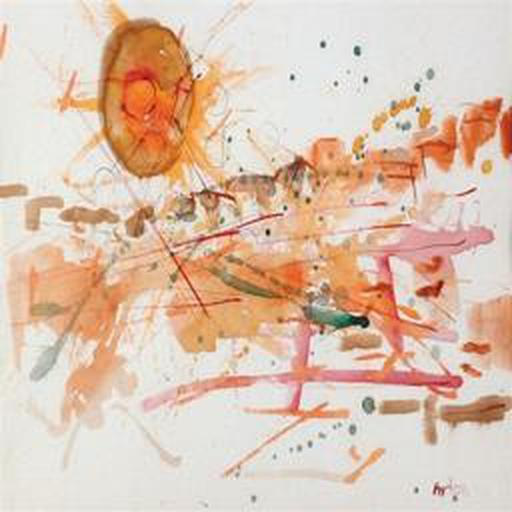

In [ ]:
image = ex['image']
image

## Loading ViT Feature Extractor

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing!

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


If we print a feature extractor, we can see its configuration.

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[0.9294, 0.9137, 0.9059,  ..., 0.7412, 0.7569, 0.7725],
          [0.9059, 0.8824, 0.8745,  ..., 0.7333, 0.7412, 0.7647],
          [0.8745, 0.8588, 0.8510,  ..., 0.7176, 0.7333, 0.7490],
          ...,
          [0.8275, 0.8039, 0.7882,  ..., 0.6941, 0.6941, 0.7020],
          [0.8353, 0.8118, 0.7961,  ..., 0.7020, 0.7020, 0.7098],
          [0.8588, 0.8353, 0.8275,  ..., 0.7255, 0.7333, 0.7412]],

         [[0.8588, 0.8431, 0.8353,  ..., 0.7333, 0.7490, 0.7647],
          [0.8353, 0.8118, 0.8118,  ..., 0.7255, 0.7333, 0.7569],
          [0.8196, 0.8039, 0.7961,  ..., 0.7098, 0.7255, 0.7412],
          ...,
          [0.8039, 0.7804, 0.7647,  ..., 0.6706, 0.6706, 0.6784],
          [0.8118, 0.7882, 0.7725,  ..., 0.6784, 0.6784, 0.6863],
          [0.8353, 0.8118, 0.8039,  ..., 0.7020, 0.7098, 0.7176]],

         [[0.8196, 0.8039, 0.7804,  ..., 0.7176, 0.7333, 0.7490],
          [0.8118, 0.7882, 0.7647,  ..., 0.7098, 0.7176, 0.7412],
          [0.8039, 0.7882

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.8196,  0.8039,  0.7961,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8275,  0.8118,  0.8039,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8353,  0.8275,  0.8275,  ...,  0.7490,  0.7961,  0.8275],
          ...,
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8353,  0.8510],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8275,  0.8431],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8431,  0.8588]],

         [[ 0.4745,  0.4431,  0.4745,  ...,  0.4431,  0.4431,  0.4353],
          [ 0.4824,  0.4588,  0.4745,  ...,  0.4353,  0.4275,  0.4275],
          [ 0.4667,  0.4588,  0.4902,  ...,  0.4118,  0.4275,  0.4353],
          ...,
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4588,  0.4510],
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4510,  0.4431],
          [ 0.4196,  0.4275,  0.4353,  ...,  0.4588,  0.4667,  0.4588]],

         [[-0.0902, -0.0196, -0.0824,  ..., -0.1294, -0.1294, -0.0824],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [ ]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.8196,  0.8039,  0.7961,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8275,  0.8118,  0.8039,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8353,  0.8275,  0.8275,  ...,  0.7490,  0.7961,  0.8275],
          ...,
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8353,  0.8510],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8275,  0.8431],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8431,  0.8588]],

         [[ 0.4745,  0.4431,  0.4745,  ...,  0.4431,  0.4431,  0.4353],
          [ 0.4824,  0.4588,  0.4745,  ...,  0.4353,  0.4275,  0.4275],
          [ 0.4667,  0.4588,  0.4902,  ...,  0.4118,  0.4275,  0.4353],
          ...,
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4588,  0.4510],
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4510,  0.4431],
          [ 0.4196,  0.4275,  0.4353,  ...,  0.4588,  0.4667,  0.4588]],

         [[-0.0902, -0.0196, -0.0824,  ..., -0.1294, -0.1294, -0.0824],
          [-0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-20-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
labels = ['ai', 'real']
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label= {'1': 'ai', '0': 'real'},
    label2id= {'ai': '1', 'real': '0'}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
training_args = TrainingArguments(
  output_dir="./vit-base-aiornot-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=3,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [ ]:
prepared_ds["train"][0]

{'pixel_values': tensor([[[ 0.8196,  0.8039,  0.7961,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8275,  0.8118,  0.8039,  ...,  0.7569,  0.7882,  0.8039],
          [ 0.8353,  0.8275,  0.8275,  ...,  0.7490,  0.7961,  0.8275],
          ...,
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8353,  0.8510],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8275,  0.8431],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.8118,  0.8431,  0.8588]],
 
         [[ 0.4745,  0.4431,  0.4745,  ...,  0.4431,  0.4431,  0.4353],
          [ 0.4824,  0.4588,  0.4745,  ...,  0.4353,  0.4275,  0.4275],
          [ 0.4667,  0.4588,  0.4902,  ...,  0.4118,  0.4275,  0.4353],
          ...,
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4588,  0.4510],
          [ 0.4275,  0.4275,  0.4431,  ...,  0.4588,  0.4510,  0.4431],
          [ 0.4196,  0.4275,  0.4353,  ...,  0.4588,  0.4667,  0.4588]],
 
         [[-0.0902, -0.0196, -0.0824,  ..., -0.1294, -0.1294, -0.0824],
          [-

In this part, we split the prepared dataset into train and test as DatasetDict (70/30).

In [ ]:
# 70% train, 30% test and val
train_test = prepared_ds['train'].train_test_split(test_size=0.3)
# train_test

In [ ]:
# 30% test and val: 20% test and 10% validation
test_val = train_test['test'].train_test_split(test_size=0.5)
# test_val

In [ ]:
train_data = train_test['train']
test_data = test_val['train']
val_data = test_val['test']

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    train_dataset = train_data,
    eval_dataset = val_data,
    tokenizer = feature_extractor,
)

This section takes a long time about 33 mins.

In [ ]:
train_results = trainer.train()
# trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.214500,0.243481,0.907268
200,0.227500,0.435275,0.843895
300,0.335200,0.183351,0.928034
400,0.229200,0.300578,0.903330
500,0.186300,0.194488,0.917293
600,0.184500,0.216017,0.906910
700,0.181000,0.160172,0.939492
800,0.196500,0.129460,0.953813
900,0.128100,0.131182,0.954887
1000,0.154000,0.161878,0.948084


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 2821559855GF
  train_loss               =       0.1119
  train_runtime            =   0:33:47.52
  train_samples_per_second =       19.283
  train_steps_per_second   =        1.206


In [ ]:
metrics = trainer.evaluate(test_data)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9678
  eval_loss               =      0.093
  eval_runtime            = 0:00:40.74
  eval_samples_per_second =     68.551
  eval_steps_per_second   =       8.59


An Example of misclassified image

In [ ]:
image1 = train_test['test']
tensor = image1[100]
tensor

image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load an image processor to preprocess the image and return the input as torch tensors:

In [ ]:
inputs = image_processor(tensor['pixel_values'].to(torch.uint8), return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 2 ImageNet classes
predicted_label = logits.argmax(-1).item()
# print(model.config.id2label[predicted_label])

In [ ]:
target_label = image1[100]['labels']
target_label

0

In [ ]:
predicted_label 

1